In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from torchvision import models, transforms
from torchvision.models import resnet50

from tqdm import tqdm, tqdm_notebook
from collections import Counter
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
BATCH_SIZE = 128
DEVICE = torch.device("cuda")

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, shuffle=True, random_state=42)

In [15]:
n_classes = len(np.unique(train_val_labels))
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

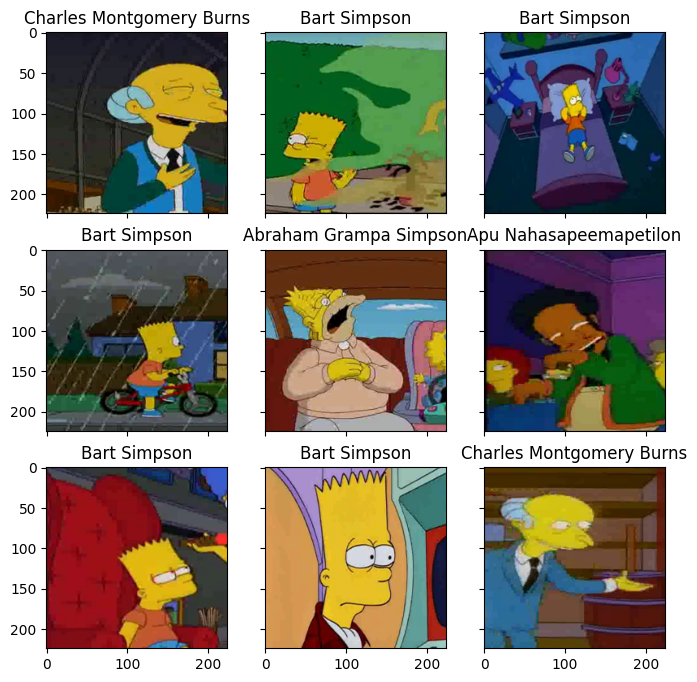

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

In [28]:
def fit_epoch(model, train_loader, optimizer, criterion):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
    
  for X, y in train_loader:
    #X = X.to(DEVICE)
    #y = y.to(DEVICE)
    optimizer.zero_grad()

    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    preds = torch.argmax(pred, 1)
    running_loss += loss.item() * y.size(0)
    running_corrects += torch.sum(preds == y.data)
    processed_data += y.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data
  return train_loss, train_acc

In [29]:
def eval_epoch(model, val_loader, criterion):
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  for X, y in val_loader:
    #X = X.to(DEVICE)
    #y = y.to(DEVICE)

    with torch.set_grad_enabled(False):
      pred = model(X)
      loss = criterion(pred, y)
      preds = torch.argmax(pred, 1)

    running_loss += loss.item() * y.size(0)
    running_corrects += torch.sum(preds==y.data)
    processed_data += y.size(0)

  val_loss = running_loss / processed_data
  val_acc = running_corrects.cpu().numpy() / processed_data
  return val_loss, val_acc

In [30]:
def train(model, train_dataloader, val_dataloader, num_epoch, optimizer, criterion):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=num_epoch) as pbar_outer:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
      
        for epoch in range(num_epoch):
            model.train()
    
            train_loss, train_acc = fit_epoch(model, train_dataloader, optimizer, criterion)
            print(train_loss, train_acc)
            scheduler.step()
            
            model.eval()
            val_loss, val_acc = eval_epoch(model, val_dataloader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history


In [31]:
def predict(model, test_loader):
    with torch.inference_mode():
        logits = []

        for inputs in test_loader:
            #inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [32]:
model = models.resnet50(weights="IMAGENET1K_V2")

In [33]:
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=42, bias=True)

In [34]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)
#model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [35]:
history = train(model, train_dataloader, val_dataloader, 10, optimizer, criterion)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.6199064967413831 0.8513918083954392


epoch:  10%|█         | 1/10 [53:38<8:02:46, 3218.51s/it]


Epoch 001 train_loss: 0.6199     val_loss 0.3094 train_acc 0.8514 val_acc 0.9184
0.1460954343158657 0.9613351168864259


epoch:  20%|██        | 2/10 [1:40:35<6:37:40, 2982.51s/it]


Epoch 002 train_loss: 0.1461     val_loss 0.2007 train_acc 0.9613 val_acc 0.9538
0.09449265274517672 0.9745843684311103


epoch:  30%|███       | 3/10 [2:29:02<5:43:56, 2948.04s/it]


Epoch 003 train_loss: 0.0945     val_loss 0.2575 train_acc 0.9746 val_acc 0.9333
0.06521204396483397 0.9808905025797822


epoch:  40%|████      | 4/10 [3:16:54<4:51:48, 2918.03s/it]


Epoch 004 train_loss: 0.0652     val_loss 0.1976 train_acc 0.9809 val_acc 0.9513
0.02156864560779434 0.9954137206191477


epoch:  50%|█████     | 5/10 [4:05:06<4:02:22, 2908.41s/it]


Epoch 005 train_loss: 0.0216     val_loss 0.1043 train_acc 0.9954 val_acc 0.9765
0.005901248228388407 0.9992993184279253


epoch:  60%|██████    | 6/10 [22:42:01<27:26:59, 24704.96s/it]


Epoch 006 train_loss: 0.0059     val_loss 0.0998 train_acc 0.9993 val_acc 0.9792
0.0031255294839990437 0.9996815083763297


epoch:  70%|███████   | 7/10 [23:27:28<14:35:59, 17519.84s/it]


Epoch 007 train_loss: 0.0031     val_loss 0.0979 train_acc 0.9997 val_acc 0.9807
0.002159705697233875 0.9997452067010638


epoch:  80%|████████  | 8/10 [24:15:00<7:08:20, 12850.26s/it] 


Epoch 008 train_loss: 0.0022     val_loss 0.0982 train_acc 0.9997 val_acc 0.9801
0.001550328348408917 0.9998089050257978


epoch:  90%|█████████ | 9/10 [25:01:18<2:41:41, 9701.34s/it] 


Epoch 009 train_loss: 0.0016     val_loss 0.0983 train_acc 0.9998 val_acc 0.9807
0.0014477201976063347 0.9998089050257978


epoch: 100%|██████████| 10/10 [25:50:10<00:00, 9301.09s/it] 


Epoch 010 train_loss: 0.0014     val_loss 0.0985 train_acc 0.9998 val_acc 0.9797


In [36]:
loss, acc, val_loss, val_acc = zip(*history)

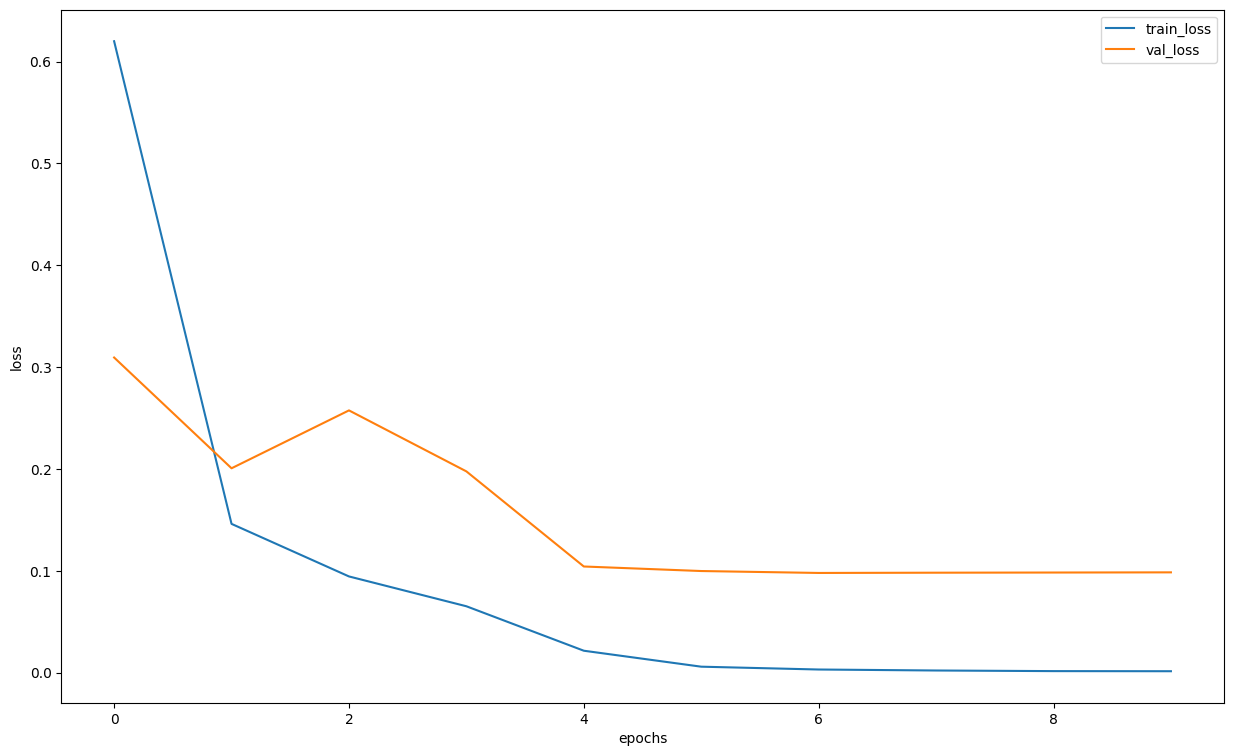

In [37]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

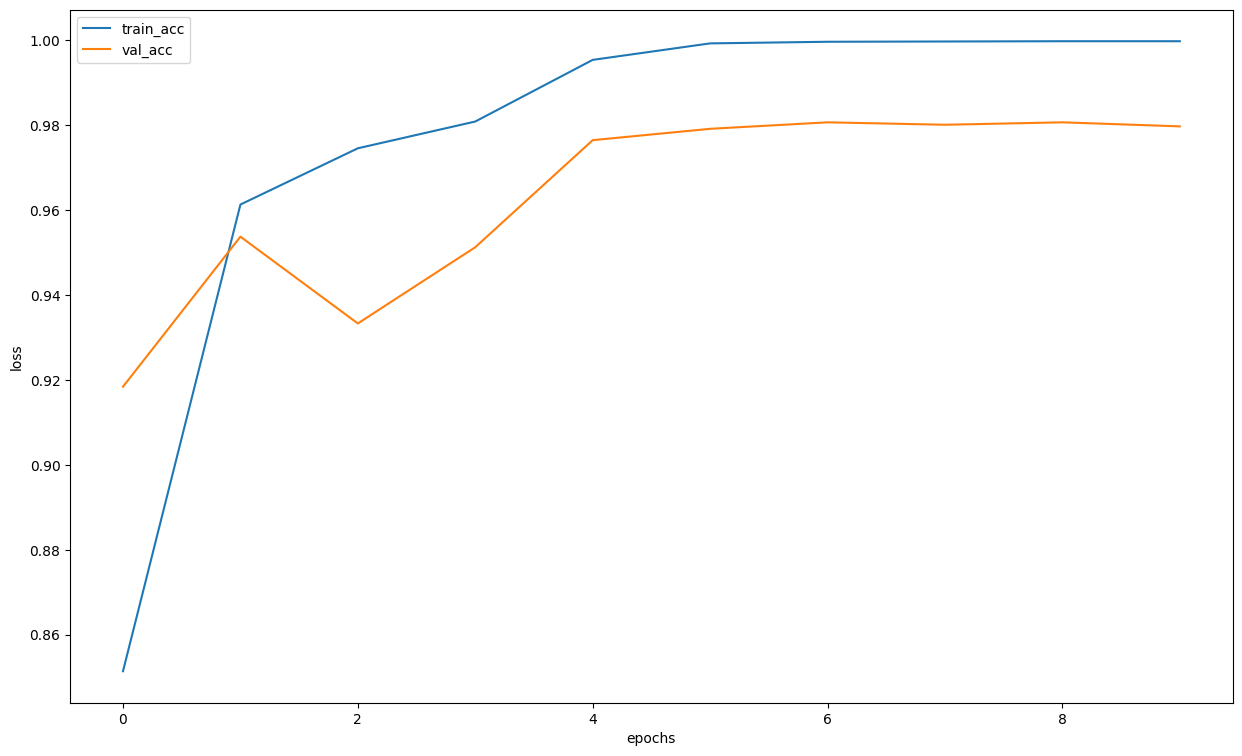

In [38]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [39]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [40]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [val_dataset.label_encoder.classes_[i] for i in y_pred]

f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9500000000000001


In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model, test_loader)

preds = val_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [1]:
my_submit = pd.read_csv('journey-springfield/sample_submission.csv')
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('submisson.csv', index=False)
my_submit.head()

NameError: name 'pd' is not defined